# Análise base de vendas 'Brazilian Ecommerce'

- Base utilizada: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv (**obs.:** antes de iniciar a análise, as tabelas foram unidas em um banco de dados denominado 'BancoDadosVendas.db' 
<br><br>
- **Desafio proposto:** ajudar a área de negócios a **entender se entregas atrasadas estão sendo um problema** para a empresa com a finalidade da **aprovação de um investimento em uma área de melhoria da experiência do cliente ao ter um atraso na entrega**
<br><br>
- Algumas considerações são importantes
    - O **time de logística não considera que o atraso na entrega é um problema relevante** e falou que, em média, as entregas estão sendo feitas 10 dias antes do prazo combinado
    - Não é desejado a previsão de uma entrega atrasada, apenas a **exposição que esse é um problema que pode impactar os clientes**
   

## Importar bibliotecas

In [11]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

## Conectar com o banco de dados

In [12]:
conexao = sqlite3.connect('BancoDadosVendas.db')
cursor = conexao.cursor()

## Função de fazer consulta no banco

In [13]:
def consulta_sql(comando):
    cursor.execute(comando)
    resultado = cursor.fetchall()
    resultado = pd.DataFrame(resultado)
    if resultado.shape[1]>0:
        lista_colunas = (coluna[0] for coluna in cursor.description)
        resultado.columns = lista_colunas
        return resultado

## Olhar a tabela de pedidos e realizar os primeiros tratamentos

In [14]:
orders = consulta_sql('SELECT * FROM orders')
orders.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [15]:
# verificando se todos os pedidos estão com o status de entregue
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [16]:
#verificando as informações das colunas
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          99441 non-null  int64 
 1   order_id                       99441 non-null  object
 2   customer_id                    99441 non-null  object
 3   order_status                   99441 non-null  object
 4   order_purchase_timestamp       99441 non-null  object
 5   order_approved_at              99281 non-null  object
 6   order_delivered_carrier_date   97658 non-null  object
 7   order_delivered_customer_date  96476 non-null  object
 8   order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB


In [17]:
#transformando as colunas de data que estão com o forrmato de object para o formato de data

colunas_data = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date','order_estimated_delivery_date']
for coluna in colunas_data:
    orders[coluna] = pd.to_datetime(orders[coluna], format = '%Y-%m-%d %H:%M:%S')


In [18]:
#verificando se agora os formatos estão corretos
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          99441 non-null  int64         
 1   order_id                       99441 non-null  object        
 2   customer_id                    99441 non-null  object        
 3   order_status                   99441 non-null  object        
 4   order_purchase_timestamp       99441 non-null  datetime64[ns]
 5   order_approved_at              99281 non-null  datetime64[ns]
 6   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 7   order_delivered_customer_date  96476 non-null  datetime64[ns]
 8   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), int64(1), object(3)
memory usage: 6.8+ MB


## Verificando se existe atraso

In [19]:
#criando uma coluna com o mês e ano que o pedido foi feito
orders['mes'] = (orders.loc[:,'order_purchase_timestamp']).dt.to_period('M')

#verificando se temos quantidade boa de dados em todos os meses/anos
orders.mes.value_counts().sort_values()

#retirando todos os dados do ano de 2016 pois não apresentam dados em quantidade significativa
orders = orders.loc[orders.mes.dt.year > 2016,:]


In [20]:
#criando uma coluna para calcular a quantidade de dias entre o previsto e o realizado (valor positivo é pq está atrasado )
orders['Atraso'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days

#calculando a media de atraso
media_atraso = orders.Atraso.mean()
print (f'Média de atraso: {media_atraso:.0f} dias (negativo: entregue antes do prazo // positivo: com atraso)')

#numero de entregas com atraso
num_entregas_atraso = orders.loc[orders.Atraso > 0, 'Atraso'].count()
print (f'Entregas com atraso: {num_entregas_atraso}')

#numero de entregas sem atraso
num_entregas_sem_atraso = orders.loc[orders.Atraso <= 0, 'Atraso'].count()
print (f'Entregas sem atraso: {num_entregas_sem_atraso}')

#numero de pedidos que não estão com data de entrega
num_faltando = orders.loc[orders.Atraso.isnull(), 'order_id'].count()

#porcentagem de entregas com atraso
porcentagem = (num_entregas_atraso)/(num_entregas_atraso + num_entregas_sem_atraso + num_faltando)
print (f'Porcentagem com atraso: {porcentagem:.2%}')

#porcentagem de pedidos que não estão com data de entrega
porc_faltando = num_faltando / (num_entregas_atraso + num_entregas_sem_atraso + num_faltando )
print (f'Porcentagem sem data de entrega: {porc_faltando:.2%}')

#verificando se existe pedido com status de entregue mas que não está com a data preenchida
entregue_semdata = orders.loc[(orders.Atraso.isnull())&(orders.order_status == 'delivered'), 'order_status'].count()
print (f'{entregue_semdata} pedidos com status de entregue, porém, faltando essa data.')

Média de atraso: -12 dias (negativo: entregue antes do prazo // positivo: com atraso)
Entregas com atraso: 6532
Entregas sem atraso: 89672
Porcentagem com atraso: 6.59%
Porcentagem sem data de entrega: 2.93%
8 pedidos com status de entregue, porém, faltando essa data.


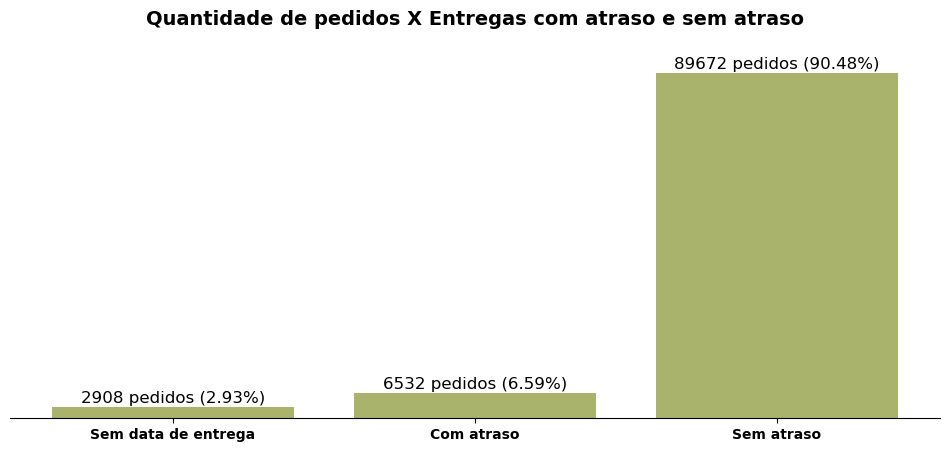

In [21]:
#plotar o percentual de pedidos com atraso X sem atraso em um gráfico de barras
fig, ax = plt.subplots(figsize = (12,5))
height = [num_faltando, num_entregas_atraso, num_entregas_sem_atraso]
ax.bar(x = [1,2,3], height = height, color = '#AAB36B')
ax.set_xticks(ticks = [1,2,3],labels=['Sem data de entrega', 'Com atraso', 'Sem atraso'], weight = 'bold')
for i in range(1,4):
    ax.annotate(f'{height[i-1]} pedidos ({height[i-1]/(num_faltando + num_entregas_atraso + num_entregas_sem_atraso):.2%})',
                xy = (i, height[i-1]), xytext = (0,3), textcoords = 'offset points', ha = 'center',
               fontsize = 12)
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.set_ylim(0,100000)
ax.yaxis.set_visible(False)
ax.set_title('Quantidade de pedidos X Entregas com atraso e sem atraso', fontsize = 14, fontweight = 'bold')
plt.show()



Com base nos cálculos realizados, nota-se que cerca de 3% dos pedidos não possuem informações sobre a data da entrega. Eles são pedidos que estão com outro status na base de dados (cancelados, em trânsito, etc.). Porém, também existem alguns pedidos que estão com status de entregue mas que está faltando a informação da data de entrega. Isso levanta a hipótese de existir algum erro de preenchimento ou falta de atualização das informações sobre determinados pedidos.

Contando somente os pedidos que possuímos informação sobre a data de entrega, foi observado que os pedidos são entregues em média com 12 dias de antecedência, porém, cerca de 7% dos pedidos são entregues com algum atraso. Vamos investigar esses pedidos com atraso para entender melhor a situação das entregas e a satisfação dos clientes.

In [22]:
#deixando a base somente com os pedidos que possuem data de entrega
orders = orders.loc[orders.Atraso.notnull(), :]

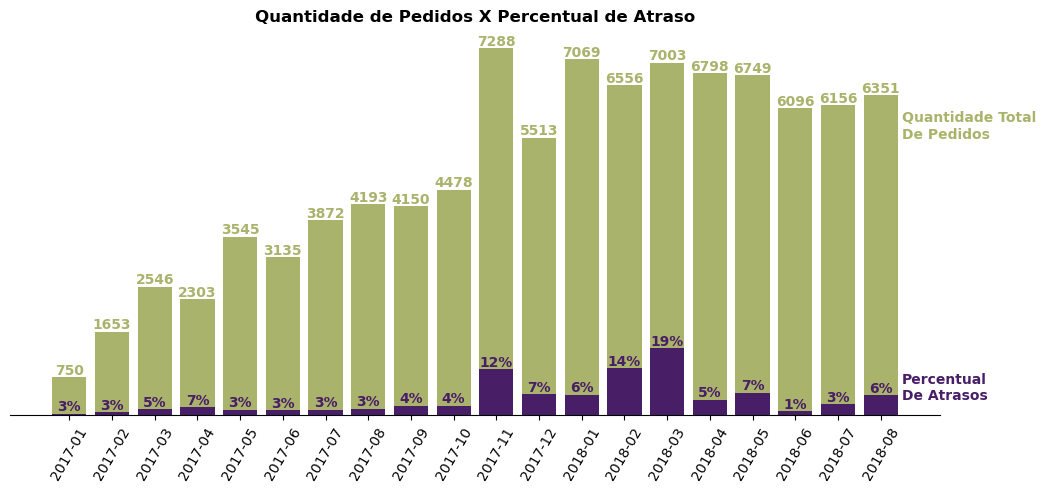

In [23]:
#visualizando o percentual de atrasos por mês
quantidade_total_mes = orders.groupby('mes')['Atraso'].count()
quantidade_atrasada_mes = orders.loc[orders.Atraso>0,:].groupby('mes')['Atraso'].count()
percentual_atrasado_mes = (quantidade_atrasada_mes/quantidade_total_mes)*100

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(x = np.arange(len(quantidade_atrasada_mes)), height = quantidade_total_mes, color = '#AAB36B')
ax.bar(np.arange(len(quantidade_atrasada_mes)), quantidade_atrasada_mes, color = '#481E66')
ax.set_xticks(ticks = np.arange(len(quantidade_atrasada_mes)), labels = quantidade_total_mes.index, rotation = 60 )
for i in range(len(quantidade_atrasada_mes)):
    ax.annotate(f'{percentual_atrasado_mes[i]:.0f}%', (i,quantidade_atrasada_mes[i]), color = '#481E66', fontweight = 'bold',
               ha = 'center', xytext=(0,2), textcoords = 'offset points')
    ax.annotate(quantidade_total_mes[i], (i,quantidade_total_mes[i]), color = '#AAB36B', fontweight = 'bold',
               ha = 'center', xytext=(0,2), textcoords = 'offset points')

ax.annotate('Quantidade Total\nDe Pedidos', (19.5, 5500), color ='#AAB36B', fontweight = 'bold' )    
ax.annotate('Percentual\nDe Atrasos', (19.5, 300), color ='#481E66', fontweight = 'bold' )

ax.yaxis.set_visible(False)
ax.spines[['right', 'top', 'left']].set_visible(False)
ax.set_title('Quantidade de Pedidos X Percentual de Atraso', fontweight = 'bold')
plt.show()

Do início de 2017 até o mês de outubro do mesmo ano, a empresa teve um percentual relativamente controlado de pedidos entregues com atraso, com excessão do mês de abril. Porém, com o aumento das vendas, esse percentual de atraso começou a subir e variar muito.<br><br>
Após passar por março de 2018, que foi o mês com maior percentual de atraso, pareceu que esse índice iria melhorar, entretanto, os últimos 3 meses avaliados mostram uma tendência de crescimento desse percentual. Logo, ações preventivas e corretivas devem ser tomadas.

## Olhando somente os pedidos com atraso

In [24]:
#dataframe somente com os pedidos que foram entregues atrasados
pedidos_atraso = orders.loc[orders.Atraso > 0, :]

#calculando a média e mediana
media_atraso = pedidos_atraso.Atraso.mean()
print(f'Média de atraso: {media_atraso:.0f} dias')
mediana_atraso = pedidos_atraso.Atraso.median()
print(f'Mediana: {mediana_atraso:.0f}')

Média de atraso: 11 dias
Mediana: 7


Olhando somente os pedidos atrasados, foi encontrada uma média de 11 dias de atraso. Porém, como a mediana deu um valor relativamente menor, isso indica que alguns pedidos tiveram um atraso muito grande, deslocando a média para cima.
Vamos olhar então os pedidos que tiveram atraso maior.


In [25]:
pedidos_atraso = orders.loc[orders.Atraso > 0, :].sort_values(by = 'Atraso', ascending = False)
pedidos_atraso.head(10)

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,mes,Atraso
55619,55619,1b3190b2dfa9d789e1f14c05b647a14a,d306426abe5fca15e54b645e4462dc7b,delivered,2018-02-23 14:57:35,2018-02-23 15:16:14,2018-02-26 18:49:07,2018-09-19 23:24:07,2018-03-15,2018-02,188.0
19590,19590,ca07593549f1816d26a572e06dc1eab6,75683a92331068e2d281b11a7866ba44,delivered,2017-02-21 23:31:27,2017-02-23 02:35:15,2017-03-08 13:47:46,2017-09-19 14:36:39,2017-03-22,2017-02,181.0
11399,11399,47b40429ed8cce3aee9199792275433f,cb2caaaead400c97350c37a3fc536867,delivered,2018-01-03 09:44:01,2018-01-03 10:31:15,2018-02-06 01:48:28,2018-07-13 20:51:31,2018-01-19,2018-01,175.0
81401,81401,2fe324febf907e3ea3f2aa9650869fa5,65b14237885b3972ebec28c0f7dd2220,delivered,2017-03-13 20:17:10,2017-03-13 20:17:10,2017-03-17 07:23:53,2017-09-19 17:00:07,2017-04-05,2017-03,167.0
89130,89130,285ab9426d6982034523a855f55a885e,9cf2c3fa2632cee748e1a59ca9d09b21,delivered,2017-03-08 22:47:40,2017-03-08 22:47:40,2017-03-09 08:53:20,2017-09-19 14:00:04,2017-04-06,2017-03,166.0
61610,61610,440d0d17af552815d15a9e41abe49359,7815125148cfa1e8c7fee1ff7974f16c,delivered,2017-03-07 23:59:51,2017-03-09 01:11:33,2017-03-15 13:00:08,2017-09-19 15:12:50,2017-04-07,2017-03,165.0
68769,68769,c27815f7e3dd0b926b58552628481575,f85e9ec0719b16dc4dd0edd438793553,delivered,2017-03-15 23:23:17,2017-03-15 23:23:17,2017-03-21 14:50:25,2017-09-19 17:14:25,2017-04-10,2017-03,162.0
40847,40847,d24e8541128cea179a11a65176e0a96f,beeda72b31be3b8a38b5c2b77d7705c4,delivered,2017-06-12 13:14:11,2017-06-12 13:25:11,2017-06-16 14:44:37,2017-12-04 18:36:29,2017-06-26,2017-06,161.0
38509,38509,0f4519c5f1c541ddec9f21b3bddd533a,1a8a4a30dc296976717f44e7801fdeef,delivered,2017-03-09 13:26:57,2017-03-09 13:26:57,2017-03-22 05:28:14,2017-09-19 14:38:21,2017-04-11,2017-03,161.0
54480,54480,2d7561026d542c8dbd8f0daeadf67a43,8199345f57c6d1cbe9701f92481beb8d,delivered,2017-03-15 11:24:27,2017-03-15 11:24:27,2017-03-16 09:29:16,2017-09-19 14:38:18,2017-04-13,2017-03,159.0


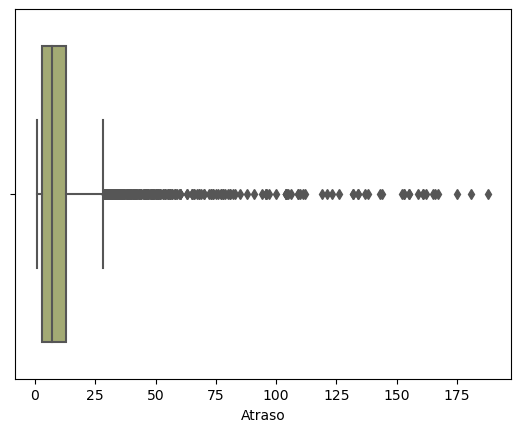

In [26]:
# gerando um boxplot para avaliar visualmente os outliers
fig, ax = plt.subplots()
sns.boxplot(x = pedidos_atraso.Atraso, color = '#AAB36B')
plt.show()

In [27]:
#olhando as informações estatísticas
pedidos_atraso.Atraso.describe()

count    6532.000000
mean       10.616810
std        14.643071
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max       188.000000
Name: Atraso, dtype: float64

De fato os dados estão bem concentrados em valores menores (75% estão entre os valores 1 e 13), porém, existe um grande desvio padrão (que inclusive é maior do que a própria média) pois o conjunto de valores apresenta uma grande quantidade de pedidos com atrasos exorbitantes, chegando a 188 dias.

## Pedidos X Review

Vamos agora verificar se o atraso impacta nas avaliações realizadas pelos clientes

In [28]:
# puxando as informações da tabela de reviews
reviews = consulta_sql('SELECT order_id, review_score, review_comment_message FROM order_reviews')

#reviews dos pedidos sem atraso
pedidos_sem_atraso = orders.loc[orders.Atraso <= 0, :]
orders_reviews_sem_atraso = pedidos_sem_atraso.merge(reviews, on = 'order_id', how = 'left')
orders_reviews_sem_atraso = orders_reviews_sem_atraso[['order_id','customer_id', 'order_status','Atraso', 'review_score', 'review_comment_message']]

media_review_sem_atraso = orders_reviews_sem_atraso.review_score.mean()
print (f'Média review pedidos sem atraso: {media_review_sem_atraso:.2f}')

#reviews dos pedidos com atraso
orders_reviews_com_atraso = pedidos_atraso.merge(reviews, on = 'order_id', how = 'left')
orders_reviews_com_atraso = orders_reviews_com_atraso[['order_id','customer_id', 'order_status','Atraso', 'review_score', 'review_comment_message']]

media_review_com_atraso = orders_reviews_com_atraso.review_score.mean()
print (f'Média reviews pedidos com atraso: {media_review_com_atraso:.2f}')

Média review pedidos sem atraso: 4.29
Média reviews pedidos com atraso: 2.27


In [29]:
#informações estatísticas do review dos pedidos sem atraso
orders_reviews_sem_atraso.review_score.describe()

count    89681.000000
mean         4.290730
std          1.148792
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

In [30]:
#informações estatísticas do review dos pedidos com atraso
orders_reviews_com_atraso.review_score.describe()

count    6407.000000
mean        2.271266
std         1.571113
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max         5.000000
Name: review_score, dtype: float64

Text(0.5, 1.0, 'Avaliação dos clientes')

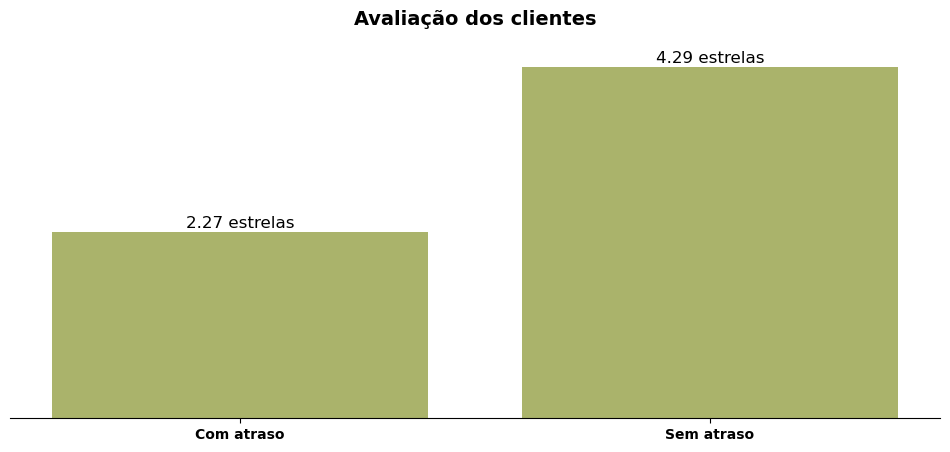

In [31]:
#plotando um gráfico com essa diferença do review
fig, ax = plt.subplots(figsize = (12,5))
height = [media_review_com_atraso, media_review_sem_atraso]
ax.bar(x = ['Com atraso', 'Sem atraso'],height = height, color = '#AAB36B')
for i in range(0,2):
    ax.annotate(f'{height[i]:.2f} estrelas', xy = (i, height[i]), xytext = (0,3), textcoords = 'offset points', ha = 'center',
               fontsize = 12)
ax.set_xticks(ticks=[0,1] , labels = ['Com atraso', 'Sem atraso'], fontweight = 'bold')
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.set_ylim(0,4.7)
ax.yaxis.set_visible(False)
ax.set_title('Avaliação dos clientes', fontsize = 14, fontweight = 'bold')

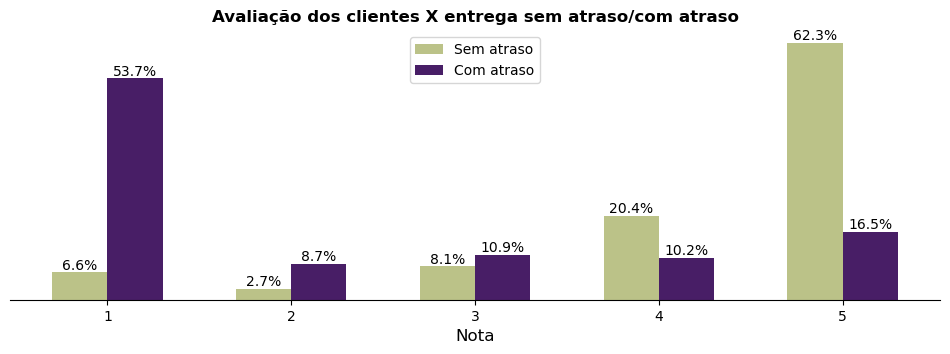

In [32]:
# distribuição da avaliação
distribuicao_com_atraso = orders_reviews_com_atraso.review_score.value_counts().reset_index()
distribuicao_com_atraso = distribuicao_com_atraso.sort_values('index')

distribuicao_sem_atraso = orders_reviews_sem_atraso.review_score.value_counts().reset_index()
distribuicao_sem_atraso = distribuicao_sem_atraso.sort_values('index')

fig, ax = plt.subplots(figsize = (12,3.5))

w = 0.3
ax1 = ax.bar(x = distribuicao_sem_atraso['index'] - w/2,
                height = (distribuicao_sem_atraso['review_score'].values)/distribuicao_sem_atraso['review_score'].sum(),
                color = '#AAB36B', alpha = 0.8, width = w, label = 'Sem atraso')
ax2 = ax.bar(x = distribuicao_com_atraso['index'] + w/2,
                height = (distribuicao_com_atraso['review_score'].values)/distribuicao_com_atraso['review_score'].sum(),
                color = '#481E66', width = w, label = 'Com atraso')

for i in range(1,6):
    valor = (distribuicao_sem_atraso.loc[distribuicao_sem_atraso['index'] == i, 'review_score'])/distribuicao_sem_atraso.review_score.sum()
    ax.annotate(f'{valor.item():.1%}', xy = (i-w/2,valor), xytext = (0,2), textcoords = 'offset points', ha = 'center')
    
    valor = (distribuicao_com_atraso.loc[distribuicao_com_atraso['index'] == i, 'review_score'])/distribuicao_com_atraso.review_score.sum()
    ax.annotate(f'{valor.item():.1%}', xy = (i+w/2,valor), xytext = (0,2), textcoords = 'offset points', ha = 'center')

    
ax.yaxis.set_visible(False)
ax.spines[['right', 'top', 'left']].set_visible(False)
ax.set_xlabel('Nota', fontsize = 12)
plt.title('Avaliação dos clientes X entrega sem atraso/com atraso', loc = 'center', fontweight='bold')
plt.legend()
plt.show()


In [33]:
#olhando os comentários de uma amostra aleatória com 30 pedidos que tiveram atraso
for mensagem in (orders_reviews_com_atraso.review_comment_message.sample(30, random_state=30)):
    if mensagem:
        print (f'Comentário: {mensagem}')
        print ('\n'+'-'*50+'\n')

Comentário: mais de 30 dias pra receber essa mercadoria. 
O prazo estava até o dia 11 e até agora nada!!!
Temos protocolo, e-mail... e nenhuma resposta de vocês!
Um absurdo!

--------------------------------------------------

Comentário: O produto foi entregue antes do prazo e em perfeitas condições.
Recomendo o stark; pois já fiz várias compras e nunca tive problemas. 

--------------------------------------------------

Comentário: Comprei o produto mais não foi entregue, toda vez que entro em contato me garantem um retorno de 48 horas de 1 dia mais nunca retornam a entrega ja esta 14 dias em atraso.

--------------------------------------------------

Comentário: Não recebi meu produto, e já está com 2 dias de atraso. Contato com o cliente é péssimo. enviei 3 emails e nunca fui respondido. Já efetuei outras compras, mas essa foi a pior até agora.

--------------------------------------------------

Comentário: tem que ter um mínimo de atenção ao cliente

---------------------------

Separando os pedidos em duas partes (com atraso e sem atraso) e comparando com a avaliação dada pelos clientes, é notável que existe uma correlação muito forte entre atraso e avaliação do cliente, pois os pedidos que tiveram algum tipo de atraso obtiveram uma avaliação muito inferior quando comparados com os pedidos que não possuiram atraso.
<br><br>
**Pedidos com atraso**<br>
Média de avaliação: 2,27<br>
Apenas 26,7% dos clientes classificaram com nota 4 ou 5<br>
Mais de 50% dos clientes classificaram com nota 1<br><br>

**Pedidos sem atraso**<br>
Média de avaliação: 4,29<br>
Mais de 80% dos clientes classificaram com nota 4 ou 5.<br>
Apenas 6,6% dos clientes cassificaram com nota 1<br><br>

**Obs:** Isso não significa que o atraso é a causa da nota baixa, pois podem existir outros motivos. Porém, já levanta a hipótese de ser sim uma das causas principais devido a alta correlação.

**Obs 2:** Pegando uma amostra aleatória de 30 pedidos com atraso, muitos dos clientes postaram comentários citando justamente o fato da entrega estar atrasada. Sendo assim, torna-se um grande indicativo que o atraso é sim um dos principais motivos de insatisfação dos clientes, demonstrando a importância de ações em cima desse fator.

## Gerando uma nuvem de frases

Para ter uma ideia ainda maior sobre os comentários dos clientes que possuem pedidos atrasados, vamos gerar uma nuvem de frases para identificar aquelas que mais estão sendo ditas.<br>
Assim, vamos verificar se os clientes realmente tem grande insatisfação com o atraso, ou, se apesar do atraso, a reclamação é maior por conta de algum outro fator


In [34]:
#gerando um texto a partir de todos os comentários de pedidos atrasados
texto = ''.join(str(mensagem) for mensagem in orders_reviews_com_atraso.review_comment_message if mensagem)
texto = texto.replace(' ', '')

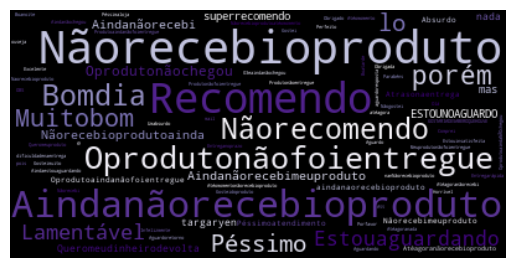

In [35]:
#gerando e plotando a nuvem de frases
wordcloud = WordCloud(colormap = 'Purples',  background_color='black').generate(texto)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Dentre as frases mais ditas, nota-se que existe sim uma grande insatisfação com relação ao atraso, pois os clientes reforçam que ainda não receberam o produto.<br><br>

Por fim, diante de todas as análises feitas, é notável que o atraso está sendo um grande problema para a empresa, pois os consumidores estão ficando insatisfeitos. 
Com isso, o setor de logística deve atuar para diminuir esse problema e os setores que cuidam da experiência dos clientes devem traçar estratégias para contornar/amenizar a situação quando for detectada que uma entrega irá atrasar, buscando manter o cliente satisfeito com a compra que foi feita.